$$
\textbf{Lógica Computacional: 2020/2021}\qquad
\textbf{Trabalho 1}\qquad
\scriptsize{Gilberto \, Cunha \quad Tomás \, Carneiro}
$$

# Problema 2

In [2]:
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from z3 import *

In [3]:
def draw_graph (graph):
    edge_labels = {(i,j): graph.edges[i,j]["value"] for i,j in graph.edges if "value" in graph.edges[i,j]}
    for i,j in graph.edges:
        if "value" not in graph.edges[i,j]:
            edge_labels[i,j] = "?"
            
    node_labels = {}
    xor_nodes, sum_nodes = ["orange", "o", []], ["orange", "o", []]
    wire_nodes, shift_nodes = ["purple", "h", []], ["orange", "o", []]
    input_nodes, output_nodes = ["green", "s", []], ["red", "s", []]
    for i in graph.nodes:
        if graph.nodes[i]["type"] == "input":
            node_labels[i] = "in"
            input_nodes[2].append(i)
        elif graph.nodes[i]["type"] == "output":
            node_labels[i] = "out"
            output_nodes[2].append(i)
        elif graph.nodes[i]["type"] == "wire":
            node_labels[i] = "$\mathcal{W}$"
            wire_nodes[2].append(i)
        elif graph.nodes[i]["type"] == "xor":
            node_labels[i] = "$\oplus$"
            xor_nodes[2].append(i)
        elif graph.nodes[i]["type"] == "sum":
            node_labels[i] = "$+$"
            sum_nodes[2].append(i)
        else:
            node_labels[i] = "$\gg_{" + str(graph.nodes[i]["r"]) + "}$"
            shift_nodes[2].append(i)
    
    f = plt.figure(figsize=(12, 12))
    plt.title("Graph")
    pos = nx.nx_pydot.graphviz_layout(graph)
    pos = nx.nx_pydot.graphviz_layout(graph, prog="dot")
    nx.draw(graph, pos=pos, labels=node_labels)
    nx.draw_networkx_nodes(graph, pos, nodelist=xor_nodes[2], font_size=9, 
                           node_shape=xor_nodes[1], node_color=xor_nodes[0], node_size=600)
    nx.draw_networkx_nodes(graph, pos, nodelist=sum_nodes[2], font_size=9, 
                           node_shape=sum_nodes[1], node_color=sum_nodes[0], node_size=600)
    nx.draw_networkx_nodes(graph, pos, nodelist=shift_nodes[2], font_size=9, 
                           node_shape=shift_nodes[1], node_color=shift_nodes[0], node_size=600)
    nx.draw_networkx_nodes(graph, pos, nodelist=input_nodes[2], font_size=9, 
                           node_shape=input_nodes[1], node_color=input_nodes[0], node_size=600)
    nx.draw_networkx_nodes(graph, pos, nodelist=output_nodes[2], font_size=9, 
                           node_shape=output_nodes[1], node_color=output_nodes[0], node_size=600)
    nx.draw_networkx_nodes(graph, pos, nodelist=wire_nodes[2], font_size=9, 
                           node_shape=wire_nodes[1], node_color=wire_nodes[0], node_size=600)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels)
    plt.show()

In [4]:
def random_binary_tree(N, M, N_i, depth_prob=0.4):
    
    # Criar output e primeiro nodo da árvore
    graph = nx.DiGraph()
    graph.add_nodes_from([0, 1])
    graph.add_edges_from([(0, 1)])
    
    # Sempre que ainda puder adicionar um novo nodo
    num_bin = 0
    keep_going, use_leaves = True, [1]
    while keep_going:
        leaves = [i for i in graph.nodes if len(list(graph.neighbors(i)))==0]
        np.random.shuffle(leaves)
        # Colocar elemento na folha da àrvore
        for i in use_leaves:
            if keep_going:
                n = len(graph.nodes)
                num_nodes = np.random.randint(1, 3)
                if num_nodes == 2:
                    num_bin += 1
                nodes = [j for j in range(n, n+num_nodes)]
                edges = [(i, j) for j in nodes]
                graph.add_nodes_from(nodes)
                graph.add_edges_from(edges)
                use_leaves += nodes
                use_leaves.remove(i)
            leaves = [i for i in graph.nodes if len(list(graph.neighbors(i)))==0]
            if num_bin >= M:
                keep_going = False
            elif len(graph.nodes) > N and len(leaves) > N_i:
                prob_keep_going = np.random.uniform()
                if prob_keep_going > depth_prob:
                    keep_going = False
                
    assert len(graph.nodes) > N and len(leaves) > N_i 
    
    return graph

def fill_circuit(graph, M, gamma, n):
    # Adicionar o tipo às gates binárias
    num_sum, bin_ops = 0, ["sum", "xor"]
    bin_gates = [j for j in list(graph.nodes) if len(list(graph.neighbors(j)))==2]
    np.random.shuffle(bin_gates)
    for i in bin_gates:
        if (num_sum+1)/M <= gamma:
            op = "sum"
        else:
            op = "xor"
        graph.nodes[i]["type"] = op
        
    # Adicionar o tipo às gates de input
    input_nodes = [j for j in list(graph.nodes) if len(list(graph.neighbors(j)))==0]
    for i in input_nodes:
        graph.nodes[i]["type"] = "input"
    
    # Adicionar o tipo e valor r aleatório às gates de shift
    num_un = 0
    unary_gates = [j for j in list(graph.nodes) if (j>0 and len(list(graph.neighbors(j)))==1)]
    graph = nx.DiGraph.reverse(graph)
    unary_gates = [j for j in unary_gates if len(list(graph.neighbors(j)))==1]
    graph = nx.DiGraph.reverse(graph)
    np.random.shuffle(unary_gates)
    for i in unary_gates:
        if len(bin_gates) + num_un < M:
            graph.nodes[i]["type"] = "shift"
            graph.nodes[i]["r"] = np.random.randint(1, 16)
            num_un += 1
        else:
            graph.nodes[i]["type"] = "wire"
        
    # Adicionar o tipo aos wires
    for i in graph.nodes:
        if "type" not in graph.nodes[i]:
            graph.nodes[i]["type"] = "wire"
        
    # Adicionar o valor da aresta de output
    j = [j for i,j in graph.edges if i==0][0]
    graph.edges[0,j]["value"] = BitVecVal(np.random.randint(2**n), n)
        
    graph = nx.DiGraph.reverse(graph)
    # Adicionar valores aleatórios aos nodos de output e soma
    for i in graph.nodes:
        if graph.nodes[i]["type"] == "sum":
            value = np.random.randint(2**n)
            j = list(graph.neighbors(i))[0]
            graph.edges[i,j]["value"] = BitVecVal(value, n)
            
    return graph

def random_graph(N, M, gamma, n, depth_prob=0.4):
    # Há 1 nodo de output, N de input e N-1 binários
    graph = random_binary_tree(M+N+1, M, N)
    graph.nodes[0]["type"] = "output"
    
    # Caso haja inputs a mais, juntá-los com wires
    input_nodes = [j for j in list(graph.nodes) if len(list(graph.neighbors(j)))==0]
    while len(input_nodes) > N:
        i = len(graph.nodes)
        graph.add_nodes_from([i, i+1])
        num_nodes = np.random.randint(2, len(input_nodes) - N + 2)
        np.random.shuffle(input_nodes)
        edges = [(input_nodes[j], i) for j in range(num_nodes)]
        edges += [(i, i+1)]
        graph.add_edges_from(edges)
        input_nodes = [j for j in list(graph.nodes) if len(list(graph.neighbors(j)))==0]
    
    # Adicionar alguns wires adicionais
    num_bin = len([j for j in list(graph.nodes) if len(list(graph.neighbors(j)))==2])
    unary_nodes = [j for j in list(graph.nodes) if (len(list(graph.neighbors(j)))==1 and j!=0)]
    np.random.shuffle(unary_nodes)
    keep_going = True
    while num_bin + len(unary_nodes) > M and keep_going:
        prob_keep = np.random.uniform()
        if prob_keep > depth_prob:
            keep_going = False
        else:
            start = 0
            node = unary_nodes[start]
            if node in list(graph.neighbors(0)):
                start += 1
                node = unary_nodes[start]
            num_con = np.random.randint(1, min(3, len(unary_nodes)))
            avail_unary = lambda j: unary_nodes[j] not in list(graph.neighbors(node)) and unary_nodes[j] not in list(graph.neighbors(0))
            edges = [(unary_nodes[j], node) for j in range(node+1, num_con+1) if avail_unary(j)]
            graph.add_edges_from(edges)
            unary_nodes = [j for j in list(graph.nodes) if (len(list(graph.neighbors(j)))==1 and j!=0)]
    
    graph = fill_circuit(graph, M, gamma, n)
        
    return graph

É dado um circuito aritmético que pode ser representado por um grafo $G = \langle \mathcal{V}, \mathcal{E} \rangle$. Este circuito dispõe de diferentes componentes:
- Inputs: Entradas do circuito
- Wires: Recebem um valor e propagam esse valor para um número arbitrário de componentes
- Gates de soma: Retornam o valor da soma de dois inteiros de 16 bits
- Gates XOR: Retornam o valor do XOR bit a bit de dois inteiros de 16 bits
- Gates de left shift rotate: Retornam o left shift rotate de um inteiro de 16 bits
- 1 Output: Resultado final do circuito

Dados o output do circuito e o resultado de cada uma das somas, é necessário inferir se os dados são consistentes e, em caso afirmativo, uma solução (inputs) do circuito.

Considere-se que se cada uma das arestas de $G$ guarda o valor do vértice na qual essa aresta tem origem, usando `BitVectors` do `z3`.

Sejam $\mathcal{W}, \mathcal{S}, \mathcal{X}, \mathcal{L} \in \mathcal{V}$ os conjuntos de wires, gates soma, gates XOR e gates left shift rotate, respetivamente. Para cada um destes vértices $\mathcal{v} \in \mathcal{V}$ considere-se que há dois conjuntos $\mathcal{I_{\mathcal{v}}}, \mathcal{O_{\mathcal{v}}} \in \mathcal{E}$ de `BitVectors` de input e output, respetivamente. Em código `python`, os `BitVectors` para todas as arestas são armazenados numa matriz de incidência $B_{ij}$.

Podemos então definir as seguintes restrições:

- Restrição dos wires, onde $\mathcal{I} = \{a_i\}$ e $\mathcal{O} = \{c\}$:

$$ \forall_{\mathcal{a_i} \in \mathcal{I_{\mathcal{v}}}} \forall_{\mathcal{v} \in \mathcal{W}}, a_i = c $$

- Restrição das gates XOR, onde $\mathcal{I} = \{a, b\}$ e $\mathcal{O} = \{c\}$:

$$ \forall_{\mathcal{v} \in \mathcal{X}}, a \oplus b = c $$

- Restrição das gates soma, onde $\mathcal{I} = \{a, b\}$ e $\mathcal{O} = \{c\}$:

$$ \forall_{\mathcal{v} \in \mathcal{S}}, a + b = c $$

- Restrição das gates left shift rotate, onde $\mathcal{I} = \{a\}$ e $\mathcal{O} = \{c\}$:

$$ \forall_{\mathcal{v} \in \mathcal{L}}, a \gg_r b = c $$

In [5]:
def l_shift_rot(c, r):
    return (c >> (n-r)) | LShR(c, r)

def solve_circuit(graph):
    H = nx.DiGraph.reverse(graph)
    solver = Solver()

    B = {}
    for i, j in H.edges:
        if "value" not in H.edges[i,j]:
            B[i,j] = BitVec(f"{i},{j}", n)
        else:
            B[i,j] = H.edges[i,j]["value"]

    for i, j in H.edges:
        out = B[i,j]
        if H.nodes[j]["type"] == "xor": # Operação XOR
            nbr1, nbr2 = list(H.neighbors(j))
            a, b = B[j, nbr1], B[j, nbr2]
            solver.add (a^b == out)
        elif H.nodes[j]["type"] == "shift": # Operação Right-Shift-Rotate
            nbr = list(H.neighbors(j))[0]
            a = B[j, nbr]
            solver.add (l_shift_rot(a, H.nodes[j]["r"]) == out)
        elif H.nodes[j]["type"] == "sum": # Operação soma
            nbr1, nbr2 = list(H.neighbors(j))
            a, b = B[j, nbr1], B[j, nbr2]
            solver.add (a+b == out)
        elif H.nodes[j]["type"] == "wire":
            nbr = list(H.neighbors(j))[0]
            solver.add(out == B[j, nbr])

    if solver.check() == sat:
        print ("Os dados são consistentes")
        m = solver.model()
        for i,j in B:
            if m[B[i,j]] != None:
                H.edges[i,j]["value"] = m[B[i,j]]

        graph = nx.DiGraph.reverse(H)
        draw_graph(graph)
        r = graph
    else:
        # print ("Os dados não são consistentes")
        r = None
        
    return r

Método para gerar circuito aleatório com $N$ inputs, $M$ gates:

1. Gerar uma árvore binária com pelo menos $M+N+1$ nodos e $N$ folhas e no máximo $M$ gates binárias
2. Caso haja mais do que $N$ inputs, reduzir o seu número para $N$ com ligações a wires
3. Ligar algumas gates unárias (tornando-as wires) a outras gates unárias (tornando-as gates binárias), nunca deixando que o número de gates total seja menor que $M$
4. Colocar os tipos corretos em cada um dos nodos do circuito

Os dados são consistentes


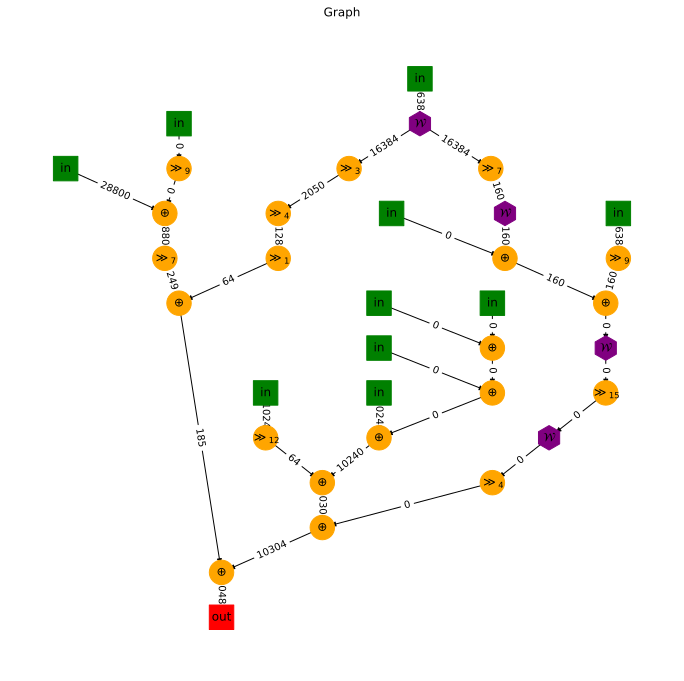

In [7]:
N, M, gamma, n = 10, 20, 0.04, 16

G = None
while G == None:
    G = random_graph(N, M, gamma, n)
    G = solve_circuit(G)